In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel, ExpSineSquared

grid = dict()
# grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),1*Matern()+1*WhiteKernel(noise_level=0.5)]
grid['kernel'] = [1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                  1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),
                  1*Matern()+1*WhiteKernel(noise_level=0.5),
                  1*ExpSineSquared(),
                  1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(1.0, 10.0)),
                  1*Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)+1*WhiteKernel(noise_level=0.5),
                ]


dataDir = Path.cwd().parent.parent/'Data/processed'
ts_dataset = pd.read_csv(dataDir/"memory_24_meanCost_minPara_65%.csv", index_col="id")

In [3]:
X = ts_dataset.iloc[:, 0:len(ts_dataset.columns)-1].copy()
y = pd.DataFrame(ts_dataset.iloc[:, -1])
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
model = GaussianProcessClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=5)
# exhausive search over different kernels
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=-1)
# fit model into the dataset
result = search.fit(X, y)

print("Mean cross-validated score of the best_estimator: ", result.best_score_)
print("Best estimator parameters: ", result.best_params_)

means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("Accuracy %.3f with: %r" % (mean, param))

Mean cross-validated score of the best_estimator:  0.9840000000000001
Best estimator parameters:  {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.932 with: {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy 0.984 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.956 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.956 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy 0.940 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=1)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=3)}
Accuracy 0.900 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}


d:\Toolbox\python\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
28 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Toolbox\python\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Toolbox\python\lib\site-packages\sklearn\gaussian_process\_gpc.py", line 715, in fit
    self.base_estimator_.fit(X, y)
  File "d:\Toolbox\python\lib\site-packages\sklearn\gaussian_process\_gpc.py", line 224, in fit
    self._constrained_optimization(
  File "d:\Toolbox\python\lib\site-packages\sklearn\gaussian_

In [7]:
y.value_counts()

label
0        15
1         9
dtype: int64

In [8]:
y_train.value_counts()

label
0        12
1         7
dtype: int64

In [73]:
y_test.value_counts()

label
0        3
1        2
dtype: int64

In [70]:
search.best_params_

{'kernel': 1**2 * DotProduct(sigma_0=1)}

In [5]:
best_kernel = 1**2 * DotProduct(sigma_0=1)
# best_kernel = 1**2 * RationalQuadratic(alpha=1, length_scale=1)
# best_kernel = 1**2 * Matern(length_scale=1, nu=1.5)
# best_kernel = 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)

model = GaussianProcessClassifier(kernel=best_kernel, random_state=5, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model.score(X_train, y_train))
print("Prediction on test data: ", model.predict(X_test))
pred_test = model.predict(X_test)
print("Prediction accuracy on test data: ", accuracy_score(y_test, pred_test))

Mean accuracy on training data:  1.0
Prediction on test data:  [0 0 0 1 1]
Prediction accuracy on test data:  1.0


In [11]:
y_test

,label
id,
9,0
24,0
6,0
14,1
4,1


In [6]:
prob_list = model.predict_proba(X_test)
prob_list

array([[0.71983485, 0.28016515],
       [0.72385594, 0.27614406],
       [0.79322326, 0.20677674],
       [0.2349517 , 0.7650483 ],
       [0.34080323, 0.65919677]])

In [9]:
cow_id = X_test.index.copy()
cow_id = cow_id.astype(str)
cow_id

Index(['9', '24', '6', '14', '4'], dtype='object', name='id')

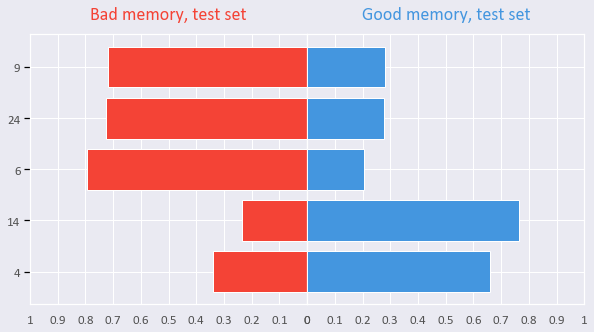

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
sns.set()

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#f44336'
color_blue = '#4496df'
index = cow_id
column0 = prob_list[:, 0]
column1 = prob_list[:, 1]
title0 = 'Bad memory, test set'
title1 = 'Good memory, test set'

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=cow_id, yticklabels=cow_id)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black') # tick color

axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
filename = 'good&bad_learner'
plt.savefig(filename+'.png', facecolor=facecolor)